**Importiere die notwendigen Packages**

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_medianalter_od4712

(int_dwh)

# Testing
### Medianalter nach Stadtkreis und Stadtquartier, seit 1993

Beschreibung
Medianalter der wirtschaftlichen Wohnbevölkerung der Stadt Zürich nach Stadtkreis und Stadtquartier seit 1993.
Datum: 15.03.2022


### Importiere die notwendigen Packages

In [24]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [25]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io

import plotly.express as px


In [26]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [27]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [28]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [29]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [30]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 3 datenstand:  1 time.struct_time(tm_year=2022, tm_mon=3, tm_mday=18, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=77, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [31]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [32]:
package_name = "bev_bestand_jahr_medianalter_od4712"

In [33]:
dataset_name = "BEV471OD4712.csv"

**Statische Pfade in DWH-Dropzones**

In [34]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [35]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [36]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [37]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [38]:
from IPython.display import Markdown as md

In [39]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_medianalter_od4712 

In [40]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_medianalter_od4712 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [41]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [42]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_medianalter_od4712/download/BEV471OD4712.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [43]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr    datetime64[ns]
KategorieLang              object
RaumSort                    int64
RaumLang                   object
Medianalter               float64
dtype: object

Berechne weitere Attribute falls notwendig

In [44]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
KategorieLang                  object
RaumSort                        int64
RaumLang                       object
Medianalter                   float64
StichtagDatJahr_str            object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [45]:
#data2betested.head(6)

In [46]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
KategorieLang                  object
RaumSort                        int64
RaumLang                       object
Medianalter                   float64
StichtagDatJahr_str            object
dtype: object

In [47]:
data2betested.shape

(1363, 6)

Beschreibe einzelne Attribute

In [48]:
data2betested.describe()

,RaumSort,Medianalter
count,1363,1363
mean,49,39
std,40,3
min,0,33
25%,11,36
50%,41,39
75%,82,40
max,123,49


Wie viele Nullwerte gibt es im Datensatz?

In [49]:
data2betested.isnull().sum()

StichtagDatJahr        0
KategorieLang          0
RaumSort               0
RaumLang               0
Medianalter            0
StichtagDatJahr_str    0
dtype: int64

Welches sind die Quartiere ohne Werte bei AnzBestWir?

In [51]:
data2betested[np.isnan(data2betested.Medianalter)]

,StichtagDatJahr,KategorieLang,RaumSort,RaumLang,Medianalter,StichtagDatJahr_str


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [52]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [53]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1363 entries, 2021-01-01 to 1993-01-01
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   KategorieLang        1363 non-null   object 
 1   RaumSort             1363 non-null   int64  
 2   RaumLang             1363 non-null   object 
 3   Medianalter          1363 non-null   float64
 4   StichtagDatJahr_str  1363 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 63.9+ KB


Int64Index([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
            2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994,
            1993],
           dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [54]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [55]:
data2betested.loc["2009"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,KategorieLang,RaumSort,RaumLang,Medianalter,StichtagDatJahr_str
StichtagDatJahr,,,,,
2009-01-01,Stadtkreis,1,Kreis 1,42,2009-01-01
2009-01-01,Stadtquartier,51,Gewerbeschule,36,2009-01-01


### Visualisierungen nach Zeitausschnitten

In [67]:
myTitle="Wohnbevölkerung nach Stadtquartier und Medianalter"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['RaumLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(data2betested.reset_index().query('RaumSort>12'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('Medianalter', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('RaumLang', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'RaumLang','Medianalter']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [68]:
data2betested.columns

Index(['KategorieLang', 'RaumSort', 'RaumLang', 'Medianalter', 'StichtagDatJahr_str'], dtype='object')

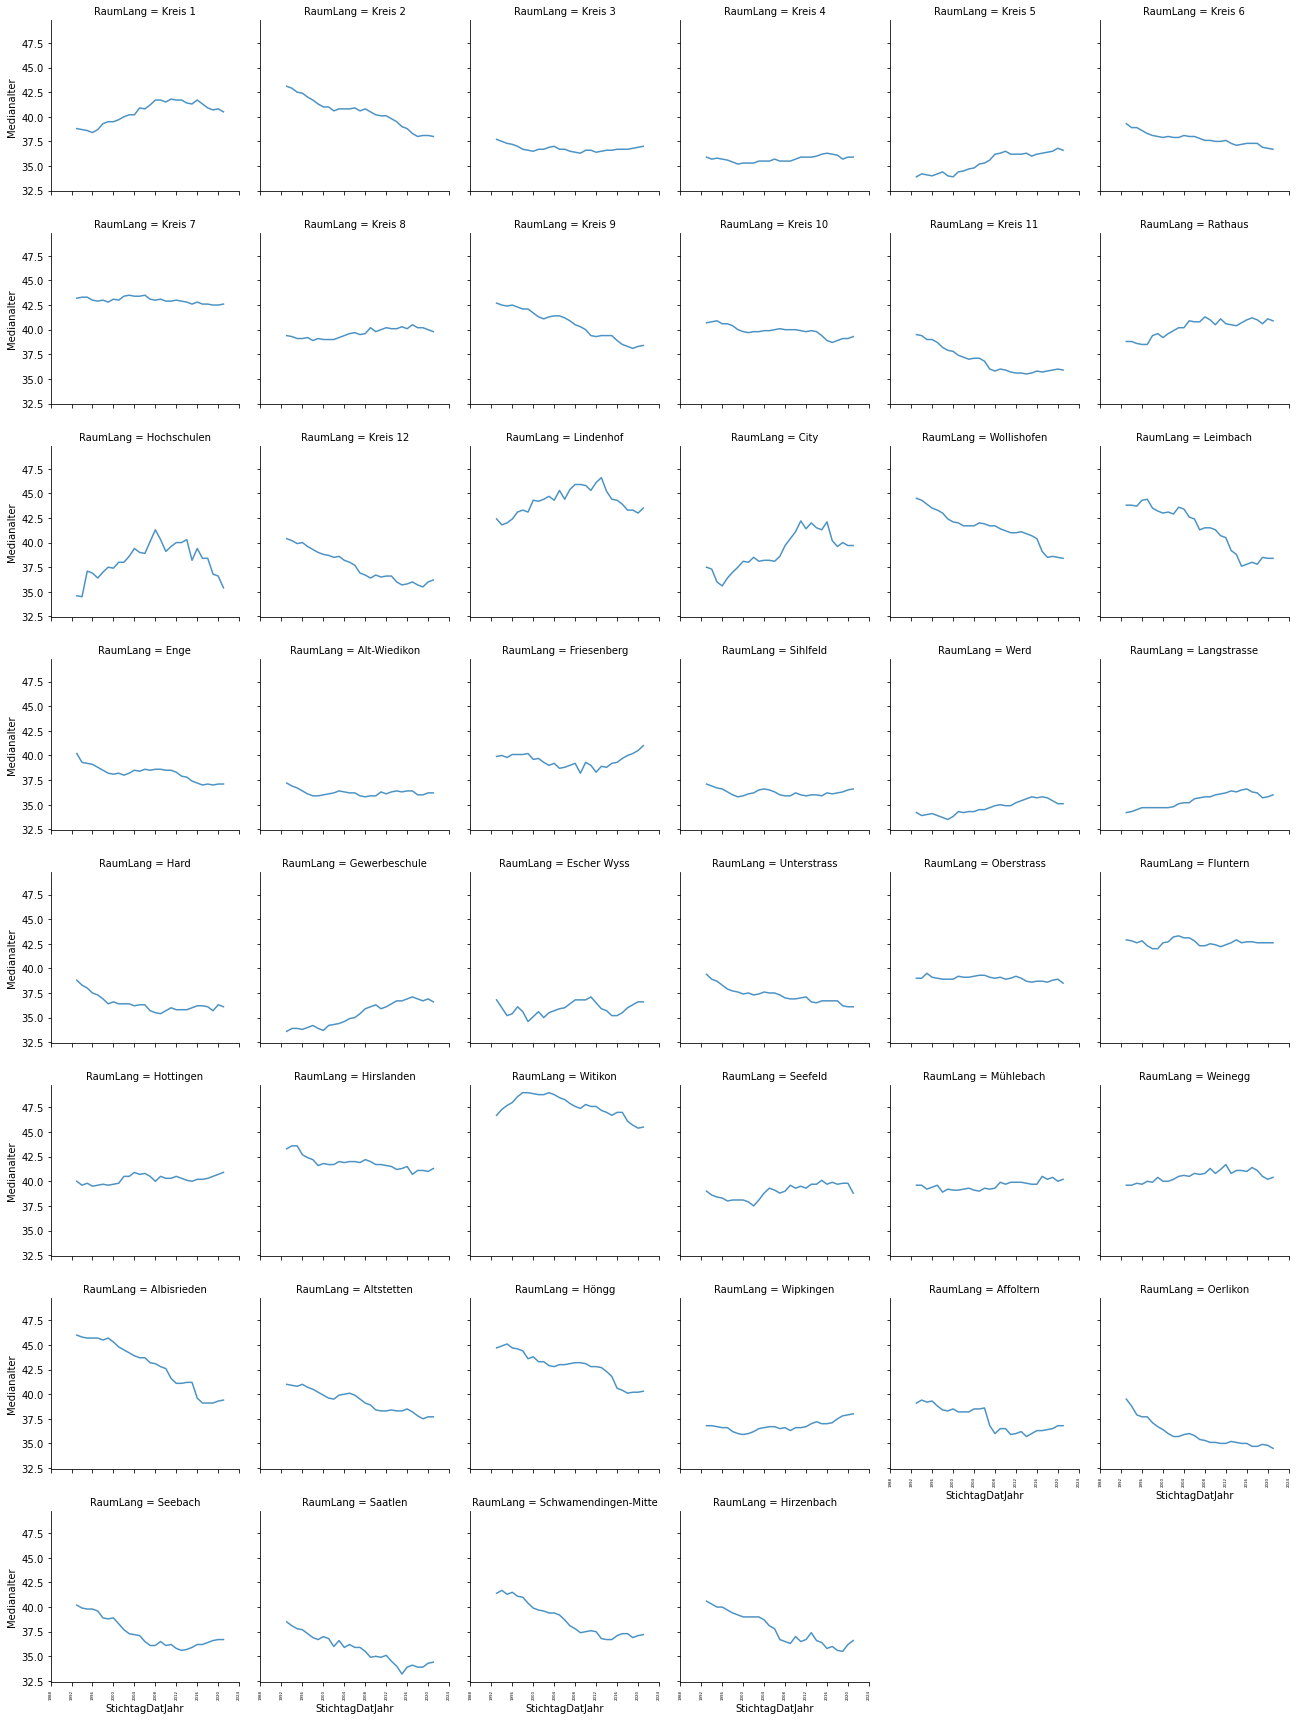

In [73]:
#g = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="HerkunftLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "AlterV05Sort", "sum_WBev", alpha=.8)
#g.add_legend()

g2 = sns.FacetGrid(data2betested.reset_index().query('RaumSort>0').sort_values('RaumSort', ascending=True), col="RaumLang", col_wrap=6, height=3,) #hue="RaumLang"
g2.map(sns.lineplot, "StichtagDatJahr","Medianalter",alpha=.8)

g2.set_xticklabels(rotation=90, fontsize=4) 
g2.add_legend()


## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=315&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------